final test accuracy 0.9724865555763245


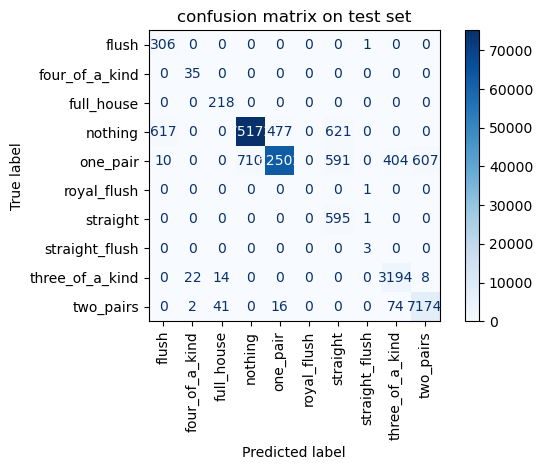

In [6]:
# step 4 evaluate and show confusion matrix

# keep comments simple and lowercase no punctuation

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
import pandas as pd

# load meta and model
with open('../artifacts/metadata.json') as f:
    meta = json.load(f)
labels = meta['label_classes']
num_classes = len(labels)
model = keras.models.load_model('../artifacts/best_so_far.keras')

# load test
X_test = np.load('../artifacts/X_test.npy')
y_test = np.load('../artifacts/y_test.npy')

# one hot labels
y_test_oh = keras.utils.to_categorical(y_test, num_classes)

# eval
loss, acc = model.evaluate(X_test, y_test_oh, batch_size=1024, verbose=0)
print('final test accuracy', acc)

# confusion matrix save and show
y_pred = model.predict(X_test, batch_size=4096, verbose=0).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title('confusion matrix on test set')
os.makedirs('../artifacts', exist_ok=True)
plt.tight_layout()
plt.savefig('../artifacts/test_confusion_matrix.png', dpi=150)
plt.show()


In [48]:
# show one random hand true and predicted using same vectorized pipeline as prep
# no sklearn onehot encoders needed to avoid dim mismatch

# load meta and model
with open('../artifacts/metadata.json') as f:
    meta = json.load(f)
suit_classes = meta['suit_classes']          # order used during prep
num_suits = meta['num_suits']
num_ranks = meta['num_ranks']                # 13
x_dim = meta['x_dim']
labels = meta['label_classes']
model = keras.models.load_model('../artifacts/best_so_far.keras')

# pick random row
df = pd.read_csv('../dataset/poker_hands.csv')
row = df.sample(1, random_state=np.random.randint(0, 1_000_000)).iloc[0]

# columns
scols = ['suit1','suit2','suit3','suit4','suit5']
rcols = ['rank1','rank2','rank3','rank4','rank5']

# map suits to ints using meta suit order
suit_to_idx = {s:i for i,s in enumerate(suit_classes)}
suits = np.array([suit_to_idx[str(row[c])] for c in scols], dtype=np.int16)
ranks = np.array([int(row[c]) for c in rcols], dtype=np.int16)

# sort cards by rank then suit so order does not matter
key = ranks * 10 + suits
order = np.argsort(key)
ranks_sorted = ranks[order]
suits_sorted = suits[order]

# one hot with numpy to match prep
r_oh = np.eye(num_ranks, dtype=np.uint8)[ranks_sorted - 1]   # 5 13
s_oh = np.eye(num_suits, dtype=np.uint8)[suits_sorted]       # 5 k

# flatten to single feature vector
x = np.concatenate([s_oh.reshape(1, -1), r_oh.reshape(1, -1)], axis=1).astype('float32')
assert x.shape[1] == x_dim, f'wrong feature dim expected {x_dim} got {x.shape[1]}'

# predict
pred = model.predict(x, verbose=0)
pred_idx = int(np.argmax(pred, axis=1)[0])
pred_label = labels[pred_idx]
true_label = str(row['ranking'])

# print hand and result
print('hand')
for i in range(5):
    print(f'card{i+1} rank {int(ranks_sorted[i])} suit {suit_classes[int(suits_sorted[i])]}')
print('true ranking', true_label)
print('predicted ranking', pred_label)


hand
card1 rank 1 suit hearts
card2 rank 3 suit hearts
card3 rank 6 suit clubs
card4 rank 9 suit clubs
card5 rank 13 suit clubs
true ranking nothing
predicted ranking nothing
